# CNN featuring data-augmentation generator
A data generator feeds the CNN one batch at a time so the whole dataset is not loaded into memory.
That data is then augmented by a augmentation generator to induce rotations and mirroring of the data.

In [1]:
import h5py as h5
import numpy as np
import random


import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam
import keras.layers.normalization 
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator

Using Theano backend.


In [2]:
PATH_DATA = 'data/train/eightieth.h5'
PATH_PREDICT_WITHOUT_GT = 'data/pred_students/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = 'data/submit/pred_eighties_from_half_1_Valentin.h5'
PATH_PREDICT_WITH_GT = 'data/pred_teachers/pred_eighties_from_half_1.h5'

BATCH_SIZE = 32

In [3]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count
    
def data_gen(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idxs = idxs[b*batch_size: (b+1)*batch_size]
            batch_idxs = sorted(batch_idxs)
            X = f['S2'][batch_idxs, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idxs, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)
    

In [4]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)         
 
train_gen = data_gen(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = data_gen(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)   

### Model definition

In [5]:
input_shape = (16,16,4)
model = Sequential()

model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(23))

model.add(Activation('softmax'))

### Model fitting

In [6]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


nb_epoch = 10
steps_per_epoch=100

aug_gen = ImageDataGenerator(rotation_range=180, horizontal_flip=True, 
                                 vertical_flip=True)

data = h5.File(PATH_DATA,'r')
nb_of_patches = data["S2"][:,:,:,0:3].shape[0]

# get a representative sample of the data
sample = random.sample(list(range(0,nb_of_patches)),  100)
sample = np.sort(sample)
x_train_sample = data["S2"][sample,:,:,0:3]

# fit parameters from data
aug_gen.fit(x_train_sample)

### Training

In [7]:
for e in range(nb_epoch):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    for s in range(steps_per_epoch):
        for X_train, Y_train in train_gen: 
            for X_batch, Y_batch in aug_gen.flow(X_train, Y_train, batch_size=BATCH_SIZE): 
                loss, acc = model.train_on_batch(X_batch, Y_batch)
                break
            break
        train_loss += loss
        train_acc += acc
    train_loss /= steps_per_epoch
    train_acc /= steps_per_epoch
    for s in range(steps_per_epoch):
        for X_val, Y_val in val_gen: 
            for X_batch, Y_batch in aug_gen.flow(X_val, Y_val, batch_size=BATCH_SIZE): 
                loss, acc = model.test_on_batch(X_batch, Y_batch)
                break
            break
        val_loss += loss
        val_acc += acc
    val_loss /= steps_per_epoch
    val_acc /= steps_per_epoch
    print("{4} - train_loss = {0:.3f}, train_acc = {1:.3f}, val_loss = {2:.3f}, "
          "val_acc = {3:.3f}".format(train_loss, train_acc, val_loss, val_acc, e))

# serialize weights to HDF5
model.save_weights("model.h5")
print("\nSaved model to disk")
   

0 - train_loss = 1.444, train_acc = 0.501, val_loss = 2.096, val_acc = 0.305
1 - train_loss = 1.327, train_acc = 0.511, val_loss = 1.510, val_acc = 0.464
2 - train_loss = 1.306, train_acc = 0.522, val_loss = 1.269, val_acc = 0.532
3 - train_loss = 1.272, train_acc = 0.522, val_loss = 1.231, val_acc = 0.532
4 - train_loss = 1.280, train_acc = 0.527, val_loss = 1.225, val_acc = 0.533
5 - train_loss = 1.273, train_acc = 0.525, val_loss = 1.184, val_acc = 0.560
6 - train_loss = 1.254, train_acc = 0.526, val_loss = 1.164, val_acc = 0.556
7 - train_loss = 1.206, train_acc = 0.544, val_loss = 1.183, val_acc = 0.555
8 - train_loss = 1.222, train_acc = 0.547, val_loss = 1.210, val_acc = 0.551
9 - train_loss = 1.205, train_acc = 0.564, val_loss = 1.223, val_acc = 0.547

Saved model to disk


# Predictions

### Utils

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [9]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

def build_h5_pred_file(pred, h5_output_path):
    if os.path.exists(h5_output_path):
        os.remove(h5_output_path)
    f = h5.File(h5_output_path, 'w')
    top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))
    top_landcover_submit[:, 0] = pred
    f.close()
    
    return 1

In [10]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [11]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def clean_confusion_matrix(confusion_matrix, classes):
    # Removes the classes not present and not predicted
    real_classes = []
    for c in range(len(classes)):
        # Was there at least one example of the c class in the test dataset
        # or did we predict c class at least one time
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

## Prediction on validation set

In [13]:
print(len(val_idxs))
val_pred_gen = prediction_generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_prediction = model.predict_generator(val_pred_gen, steps=val_batch_count, verbose=1)
print(len(val_prediction))

46800
1463/1463 [==============================] - 52s 35ms/step
46800


In [14]:
val_gt_gen = gt_generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_gt = []
for elem in val_gt_gen:
    val_gt.append(elem)
val_gt = np.vstack(val_gt)

In [15]:
val_y_true = np.argmax(val_gt, axis=1)
val_y_pred = np.argmax(val_prediction, axis = 1)

val_real_cnf_matrix, val_real_classes = clean_confusion_matrix(confusion_matrix(val_y_true, val_y_pred, 
                                                                        labels= range(23)), range(23))

Normalized confusion matrix


<IPython.core.display.Javascript object>


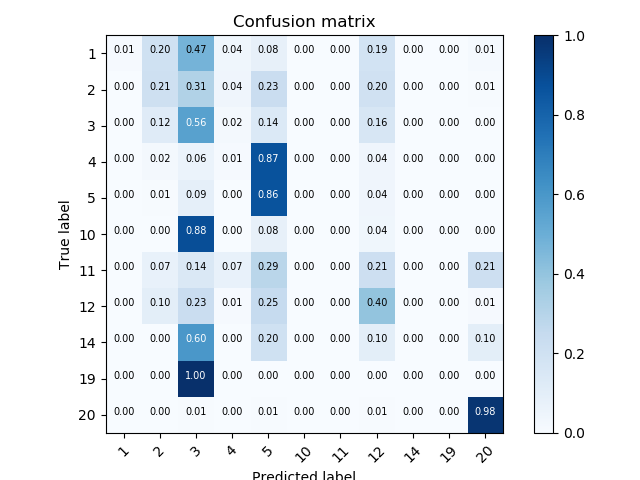

In [28]:
%matplotlib notebook
plot_confusion_matrix(val_real_cnf_matrix, classes = val_real_classes, normalize=True)

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


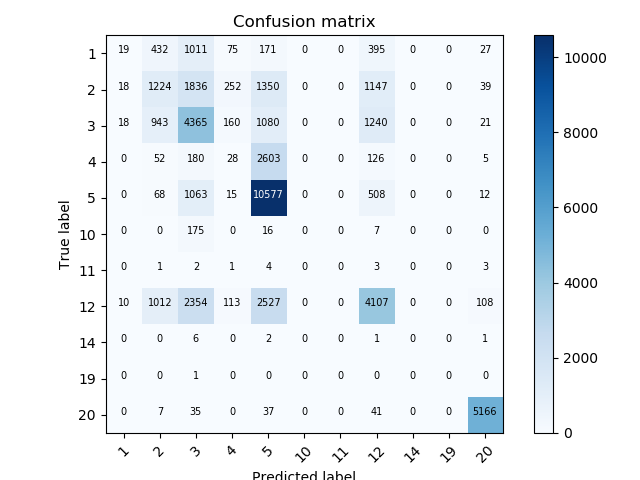

In [29]:
%matplotlib notebook
plot_confusion_matrix(val_real_cnf_matrix.astype('uint32'), classes = val_real_classes, normalize=False)

In [18]:
print('Accuracy on validation set:')
accuracy_score(val_y_true, val_y_pred)

Accuracy on validation set:


0.54457264957264961

## Prediction on test set

In [19]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))

241700
7554/7554 [==============================] - 113s 15ms/step
241700


In [20]:
build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)

1

In [21]:
gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [22]:
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))

Normalized confusion matrix


<IPython.core.display.Javascript object>


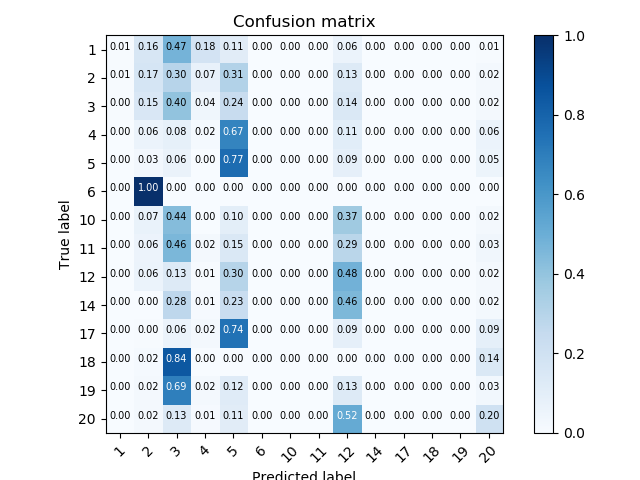

In [30]:
%matplotlib notebook
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)

Confusion matrix, without normalization


<IPython.core.display.Javascript object>


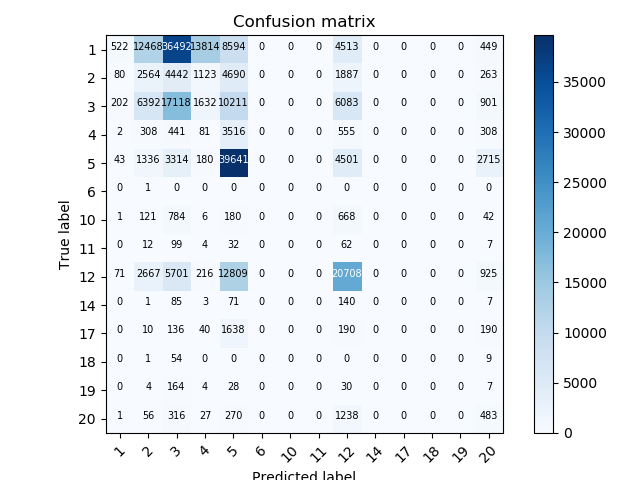

In [31]:
%matplotlib notebook
plot_confusion_matrix(real_cnf_matrix.astype('uint32'), classes = real_classes, normalize=False)

In [25]:
print('Accuracy on test set:')
accuracy_score(y_true, y_pred)

Accuracy on test set:


0.33561026065370292